In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)  # Unlimited columns
import nbimporter
# Imported from my other notebook
from data_cleanup import cleanup1
from data_cleanup import cleanup2
from data_cleanup import cleanup3

Importing Jupyter notebook from data_cleanup.ipynb


In [162]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn_pandas import DataFrameMapper
from sklearn.metrics import accuracy_score
from category_encoders.target_encoder import TargetEncoder
from sklearn.ensemble import RandomForestClassifier

In [127]:
# Import all data
sample_submission = pd.read_csv('original_data/sample_submission.csv')
test_features = pd.read_csv('original_data/test_features.csv')
train_features = pd.read_csv('original_data/train_features.csv')
train_labels = pd.read_csv('original_data/train_labels.csv')

In [3]:
# Clean data with previously defined cleanup function
X_train = cleanup3(cleanup2(cleanup1(train_features)))
X_test = cleanup3(cleanup2(cleanup1(test_features)))

In [128]:
y_true = train_labels['status_group']
y_works = [1.0 if x == 'functional' else 0.0 for x in y_true]
y_broken = [1.0 if x == 'non functional' else 0.0 for x in y_true]
y_repair = [1.0 if x == 'functional needs repair' else 0.0 for x in y_true]

# OHE + Logistic Regression
I'll start by one-hot encoding all the categorical variables and running a simple logistic regression.  Many of the features have way too much cardinality for one-hot encoding.  Let's separate them into two lists by cardinality.

In [115]:
# Define groups of columns in X_train
numericals = ['amount_tsh',
                    'date_recorded',
                    'gps_height',
                    'longitude',
                    'latitude',
                    'num_private',
                    'population',
                    'construction_year']

alt_numericals = ['amount_tsh',
                    'date_recorded',
                    'gps_height',
#                     'longitude',
#                     'latitude',
                    'num_private',
                    'population',
                    'construction_year']

categoricals = ['funder',
                     'installer',
                     'wpt_name',
                     'basin',
                     'subvillage',
                     'region',
                     'region_code',
                     'district_code',
                     'lga',
                     'ward',
                     'public_meeting',
                     'scheme_management',
                     'scheme_name',
                     'permit',
                     'extraction_type',
                     'extraction_type_group',
                     'extraction_type_class',
                     'management',
                     'management_group',
                     'payment',
                     'payment_type',
                     'water_quality',
                     'quality_group',
                     'quantity',
                     'quantity_group',
                     'source',
                     'source_type',
                     'source_class',
                     'waterpoint_type',
                     'waterpoint_type_group']

trash_cols = ['amount_tsh_trash',
                     'construction_year_trash',
                     'gps_height_trash',
                     'latitude_trash',
                     'longitude_trash',
                     'num_private_trash',
                     'population_trash']

In [142]:
# # OHE that works
X_train_cats = X_train[categoricals]
# OHE = OneHotEncoder()
# X_train_cats_expanded = OHE.fit_transform(X_train_cats)
# X_train_cats_expanded

In [159]:
X_train_cats_expanded

<59400x630 sparse matrix of type '<class 'numpy.float64'>'
	with 2197800 stored elements in Compressed Sparse Row format>

In [192]:
target_encoder = TargetEncoder()
X_TE1 = target_encoder.fit_transform(X=X_train_cats, y=y_works)

target_encoder = TargetEncoder()
X_TE2 = target_encoder.fit_transform(X=X_train_cats, y=y_broken)

target_encoder = TargetEncoder()
X_TE3 = target_encoder.fit_transform(X=X_train_cats, y=y_repair)


In [195]:
X_TE1 = X_TE1.rename(columns=(lambda x: x+'_TE1'))
X_TE2 = X_TE2.rename(columns=(lambda x: x+'_TE2'))
X_TE3 = X_TE3.rename(columns=(lambda x: x+'_TE3'))

In [199]:
X_TE_all = pd.concat([X_TE1,X_TE2,X_TE3], sort=False, axis=1)

In [200]:
X_TE_nums = pd.concat([X_TE_all, X_train[numericals]], sort=False, axis=1)

In [201]:
X_TE_all.shape

(59400, 90)

In [160]:
logreg = LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=500)
logreg.fit(X_train_cats_expanded, y_true)

/anaconda3/envs/sandbox/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/sandbox/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [161]:
y_pred = logreg.predict(X_train_cats_expanded)
accuracy_score(y_true, y_pred)

0.7607912457912458

In [158]:
y_pred = logreg.predict(X_TE_all)
accuracy_score(y_true, y_pred)

0.7311784511784511

# RFC + OHE

In [166]:
RFC = RandomForestClassifier()
RFC.fit(X_train_cats_expanded, y_true)

/anaconda3/envs/sandbox/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [167]:
y_pred = RFC.predict(X_train_cats_expanded)
accuracy_score(y_true, y_pred)

0.8871717171717172

# RFC + Target

In [168]:
RFC = RandomForestClassifier()
RFC.fit(X_TE_all, y_true)

/anaconda3/envs/sandbox/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [169]:
y_pred = RFC.predict(X_TE_all)
accuracy_score(y_true, y_pred)

0.8851515151515151

# RFC + Target + nums

In [170]:
RFC = RandomForestClassifier()
RFC.fit(X_train[numericals], y_true)

/anaconda3/envs/sandbox/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [171]:
y_pred = RFC.predict(X_train[numericals])
accuracy_score(y_true, y_pred)

0.969006734006734

# Gridsearch

In [174]:
gs = GridSearchCV(RandomForestClassifier(), cv=5, param_grid={},
                  scoring='accuracy', 
                  verbose=10)

gs.fit(X_train_cats_expanded, y_true)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/envs/sandbox/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ....................... , score=0.7851190977190472, total=  24.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.7s remaining:    0.0s
/anaconda3/envs/sandbox/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ........................ , score=0.782004881743961, total=  25.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   50.3s remaining:    0.0s
/anaconda3/envs/sandbox/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ....................... , score=0.7808080808080808, total=  25.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s
/anaconda3/envs/sandbox/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ....................... , score=0.7767676767676768, total=  26.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.7min remaining:    0.0s
/anaconda3/envs/sandbox/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ....................... , score=0.7824549587472639, total=  29.9s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.2min finished
/anaconda3/envs/sandbox/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=10)

In [175]:
gs = GridSearchCV(RandomForestClassifier(), cv=5, param_grid={},
                  scoring='accuracy', 
                  verbose=10)

gs.fit(X_TE_all, y_true)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/envs/sandbox/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ....................... , score=0.7884016496927868, total=   2.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s
/anaconda3/envs/sandbox/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ....................... , score=0.7832674017338608, total=   2.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.0s remaining:    0.0s
/anaconda3/envs/sandbox/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ....................... , score=0.7852693602693602, total=   2.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.3s remaining:    0.0s
/anaconda3/envs/sandbox/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ....................... , score=0.7794612794612794, total=   2.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   10.0s remaining:    0.0s
/anaconda3/envs/sandbox/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ....................... , score=0.7840545546388281, total=   1.9s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.3s finished
/anaconda3/envs/sandbox/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=10)

In [179]:
gs = GridSearchCV(RandomForestClassifier(), cv=5, param_grid={},
                  scoring='accuracy', 
                  verbose=10)

gs.fit(X_TE_nums, y_true)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................


/anaconda3/envs/sandbox/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ....................... , score=0.7988384816092922, total=   4.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s
/anaconda3/envs/sandbox/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ....................... , score=0.7931150576550795, total=   4.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.5s remaining:    0.0s
/anaconda3/envs/sandbox/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ....................... , score=0.7956228956228957, total=   4.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.3s remaining:    0.0s
/anaconda3/envs/sandbox/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ........................ , score=0.791077441077441, total=   4.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   20.5s remaining:    0.0s
/anaconda3/envs/sandbox/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ....................... , score=0.7926418588988046, total=   4.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.7s finished
/anaconda3/envs/sandbox/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=10)

In [181]:
gs.best_score_

0.7942592592592592

In [182]:
from xgboost import XGBClassifier
modelxgb = XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx', 
                      num_class = 3, maximize = False, eval_metric = 'merror', eta = .1,
                      max_depth = 14, colsample_bytree = .4)

In [202]:
modelxgb.fit(X_TE_nums, y_true)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, eta=0.1, eval_metric='merror', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=14, maximize=False,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nrounds='min.error.idx', nthread=None, num_class=3,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [204]:
y_pred = modelxgb.predict(X_TE_nums)
accuracy_score(y_true, y_pred)

0.9292592592592592

# Process test data

In [205]:
X_test_cats = X_test[categoricals]

target_encoder = TargetEncoder()
X_TE1 = target_encoder.fit_transform(X=X_train_cats, y=y_works)
X_test_TE1 = target_encoder.transform(X=X_test_cats)

target_encoder = TargetEncoder()
X_TE2 = target_encoder.fit_transform(X=X_train_cats, y=y_broken)
X_test_TE2 = target_encoder.transform(X=X_test_cats)

target_encoder = TargetEncoder()
X_TE3 = target_encoder.fit_transform(X=X_train_cats, y=y_repair)
X_test_TE3 = target_encoder.transform(X=X_test_cats)



X_test_TE1 = X_test_TE1.rename(columns=(lambda x: x+'_TE1'))
X_test_TE2 = X_test_TE2.rename(columns=(lambda x: x+'_TE2'))
X_test_TE3 = X_test_TE3.rename(columns=(lambda x: x+'_TE3'))

X_test_TE_all = pd.concat([X_test_TE1,X_test_TE2,X_test_TE3], sort=False, axis=1)
X_test_TE_nums = pd.concat([X_test_TE_all, X_test[numericals]], sort=False, axis=1)

In [207]:
y_test_pred = modelxgb.predict(X_test_TE_nums)

# Other

In [72]:
# # # Use a mapper to apply transformations selectively
# mapper = DataFrameMapper(
#     [([col], None) for col in other_cols] +
#     [([col], RobustScaler()) for col in numericals] +
#     [([col], OneHotEncoder()) for col in categoricals]
# )

# # # Define an estimator and param_grid
# pipe = make_pipeline(
#     mapper, 
#     LogisticRegression(solver='lbfgs', multi_class='ovr',
#                       max_iter=500))


In [ ]:
%%time
X_tweaked = mapper.fit_transform(X_train[numericals], y_true)

In [61]:
pd.DataFrame(X_tweaked, columns=mapper.transformed_names_).head()

In [62]:
%%time
pipe.fit(X_train,y_true)

CPU times: user 5.84 s, sys: 359 ms, total: 6.2 s
Wall time: 4.07 s


Pipeline(memory=None,
     steps=[('dataframemapper', DataFrameMapper(default=False, df_out=False,
        features=[(['id'], None), (['amount_tsh_trash'], None), (['construction_year_trash'], None), (['gps_height_trash'], None), (['latitude_trash'], None), (['longitude_trash'], None), (['num_private_trash'], None), (['popula...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

In [63]:
y_pred = pipe.predict(X_train)
accuracy_score(y_true, y_pred)

0.543080808080808

Alright, that was the score with all categories except for those that have thousands of possible values and make the final dataframe way too big.

# Make a submission file

In [209]:
# Make a dataframe with the answers
y_submit = pd.DataFrame({'id':test_features['id'],
                         'status_group':y_test_pred} )
# make a submission CSV file
y_submit.to_csv('DMA3.csv', index=False)

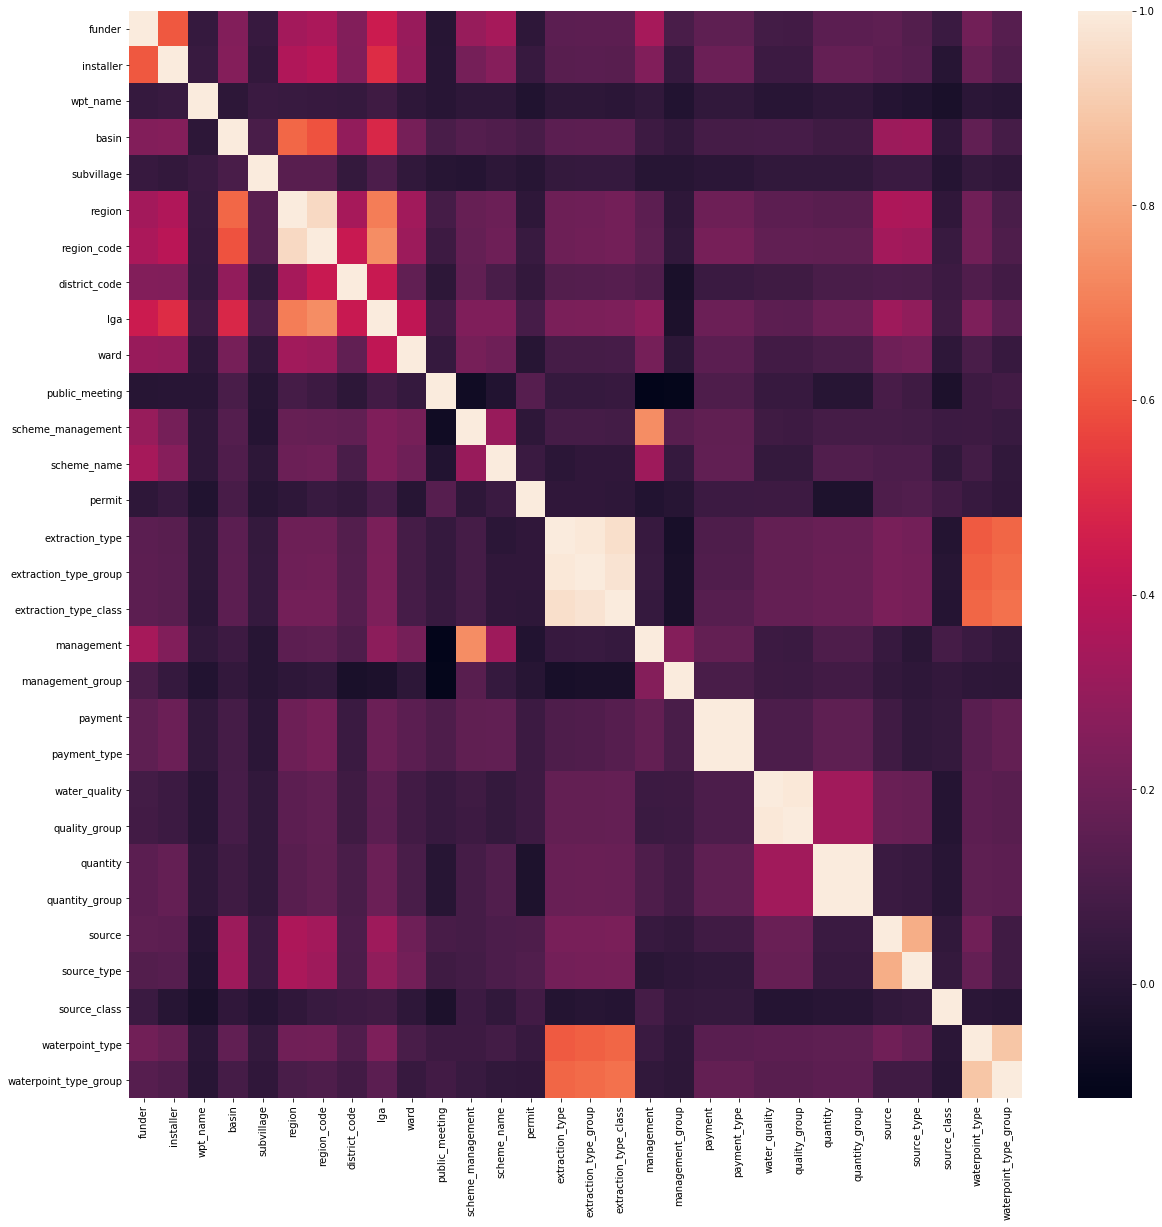

In [217]:
fig, ax = plt.subplots(figsize=(20,20))
ax = sns.heatmap(X_TE1.corr());